In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone "https://github.com/maria-natale/ProgettoFVAB"

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import os
import pandas as pd
import numpy as np

path_git = '/content/ProgettoFVAB'
filename = 'all'
path_drive = '/content/drive/MyDrive/Casillo&Natale/dataset'
dataset_dir = 'dataset_all/datasetCSV'
LANGUAGES = {
  1:'Italiano',
  2:'Inglese',
  3: 'Tedesco',
  4:'Spagnolo',
  5: 'Olandese',
  6:'Russo',
  7: 'Giapponese'}
LANGUAGES_N = {
    1:0,
    2:1,
    3:2,
    4:3,
    5:4,
    6:5,
    7:6
}


# Caricamento dati

In [ ]:
# load dataset
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header= None)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    loaded = list()
    for name in filenames:
        data = read_csv(prefix+name)
        data = scaler.fit_transform(data)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix= ''):
    filepath = path_drive+'/'+dataset_dir+'/features/'
    os.chdir(os.path.join(filepath, group))
    filenames = []
    filenames = [group+'/feature'+str(i)+'.csv' for i in range(0,66)]
    # load input data
    X= load_group(filenames, filepath)
    #load y 
    os.chdir(os.path.join(path_drive, dataset_dir, 'csv'))
    y = read_csv(filename+'_'+group.split('_')[0]+'_targets_1.csv')
    # load class output
    return X,y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix)
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix)
    print(testX.shape, testy.shape)
    validationX, validationy = load_dataset_group('validation', prefix)
    trainy['language'] = trainy['language'].map(LANGUAGES_N)
    testy['language'] = testy['language'].map(LANGUAGES_N)
    validationy['language'] = validationy['language'].map(LANGUAGES_N)
    trainy = to_categorical(trainy, len(LANGUAGES_N))
    testy = to_categorical(testy, len(LANGUAGES_N))
    validationy = to_categorical(validationy, len(LANGUAGES_N))
    print(trainX.shape, trainy.shape, testX.shape, testy.shape, validationX.shape, validationy.shape)
    return trainX, trainy, testX, testy, validationX, validationy


# Definizione del modello

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

verbose, epochs, batch_size = 0, 500, 32
def create_model():
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], len(LANGUAGES_N.keys())
    # Initialising the RNN
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = (n_timesteps, n_features))))
    model.add(Dropout(0.5))

    # Adding a second LSTM layer and Dropout layer
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True)))
    model.add(Dropout(0.5))

    # Adding a third LSTM layer and Dropout layer
    model.add(Bidirectional(LSTM(units = 100)))
    model.add(Dropout(0.5))

    # Adding the output layer
    model.add(Dense(n_outputs, activation='softmax'))

    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
    model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy']
    )

    return model

# Sperimentazione con Early Stopping

In [ ]:
def run_experiment(model, trainX, trainy, validationX, validationy, testX, testy):
  tf.random.set_seed(42)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 80)
  history = model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose, validation_data = (validationX, validationy), callbacks = [es]) 
  #model.summary()
  model.evaluate(testX, testy)
  predictions = model.predict_classes(testX) 
  print(predictions)
  return history, predictions


In [ ]:
# run the experiment
with tf.device('/device:GPU:0'):
  trainX, trainy, testX, testy, validationX, validationy = load_dataset(path_drive+'/'+dataset_dir)
  model = create_model()
  history, predictions = run_experiment(model, trainX, trainy, validationX, validationy, testX, testy)

(462, 350, 66) (462, 1)
(160, 350, 66) (160, 1)
(462, 350, 66) (462, 7) (160, 350, 66) (160, 7) (145, 350, 66) (145, 7)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 00104: early stopping
5/5 [==============================] - 2s 64ms/step - loss: 2.0665 - accuracy: 0.6438


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[3 0 0 0 4 6 0 1 2 0 0 0 0 0 0 1 6 2 1 0 1 2 2 2 0 6 0 1 4 0 0 1 0 1 6 2 0
 3 3 1 0 1 3 1 0 0 1 1 6 6 4 4 3 3 4 0 0 4 0 0 0 1 1 3 2 5 5 4 4 5 5 5 5 5
 5 4 4 5 5 3 3 4 4 4 4 4 4 4 4 4 3 2 3 3 4 4 6 6 4 4 4 4 4 4 4 4 4 6 4 6 6
 1 4 4 4 4 4 4 4 0 4 4 4 4 4 4 3 5 4 4 6 4 4 6 4 4 4 4 4 4 4 6 6 2 4 6 6 6
 6 6 6 6 6 6 0 6 0 6 3 0]


In [ ]:
from sklearn.metrics import classification_report

testy = np.argmax(testy, axis=1)
target_names = list(LANGUAGES.values())
print(classification_report(testy, predictions, target_names=target_names))

              precision    recall  f1-score   support

    Italiano       0.59      0.77      0.67        22
     Inglese       0.80      0.52      0.63        23
     Tedesco       0.67      0.60      0.63        10
    Spagnolo       0.64      0.36      0.46        25
    Olandese       0.64      0.77      0.70        47
       Russo       0.91      0.71      0.80        14
  Giapponese       0.50      0.68      0.58        19

    accuracy                           0.64       160
   macro avg       0.68      0.63      0.64       160
weighted avg       0.67      0.64      0.64       160



In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc


vis_arr = multilabel_confusion_matrix(testy, predictions, labels = list(LANGUAGES_N.values()))
print(vis_arr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in list(LANGUAGES_N.values()):
    fpr[i], tpr[i], _ = roc_curve(testy == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

[[[126  12]
  [  5  17]]

 [[134   3]
  [ 11  12]]

 [[147   3]
  [  4   6]]

 [[130   5]
  [ 16   9]]

 [[ 93  20]
  [ 11  36]]

 [[145   1]
  [  4  10]]

 [[128  13]
  [  6  13]]]


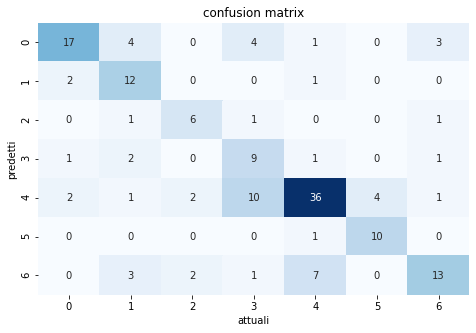

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

valori=pd.crosstab(predictions,testy)
fig=plt.figure(figsize=(17,5))
ax1=plt.subplot(121)
ax1.set_title("confusion matrix")
sns.heatmap(valori,annot=True,cmap="Blues",cbar=False)
plt.xlabel("attuali") 
plt.ylabel("predetti")
plt.savefig(path_drive+'/Risultati/grafici/ConfusionMatrixall_es.png')

17 12 5 126
12 3 11 134
6 3 4 147
9 5 16 130
36 20 11 93
10 1 4 145
13 13 6 128


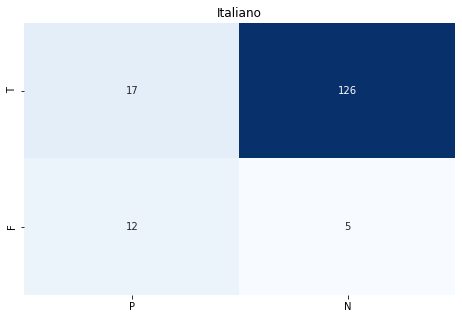

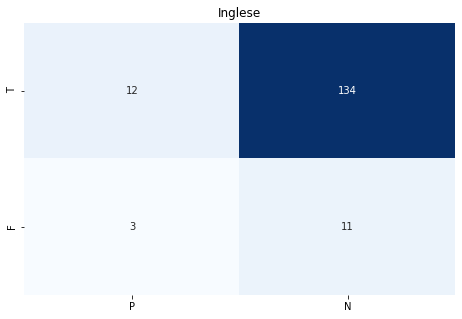

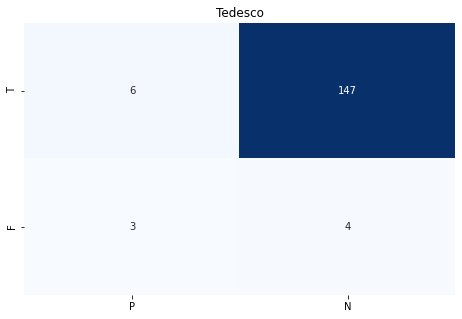

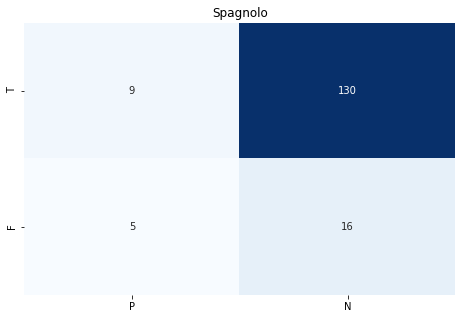

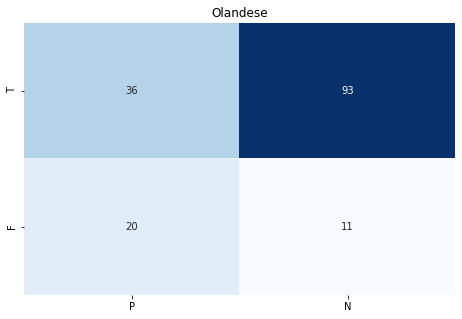

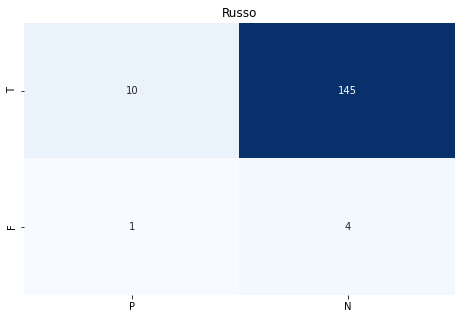

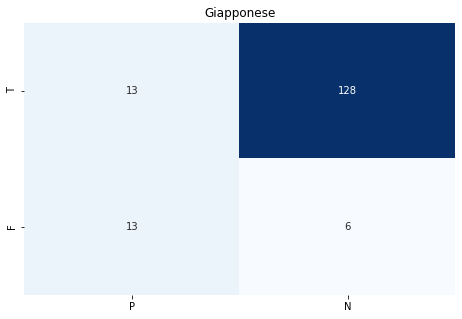

In [ ]:
for j in (list(LANGUAGES_N.keys())):
  i = LANGUAGES_N[j]
  TP= valori.iloc[i,i]
  FP= valori.iloc[i,:].sum()-TP
  FN= valori.iloc[:,i].sum()-TP
  TN= valori.sum().sum() - TP - FP - FN
  print(TP,FP,FN,TN)
  #b=[[TP,FP],[FN,TN]]
  b=[[TP,TN],[FP,FN]]
  fig=plt.figure(figsize=(17,5))
  ax1=plt.subplot(121)
  sns.heatmap(b,annot=True,cmap="Blues",cbar=False,fmt = "g")
  #plt.xlabel("POSITIVI") 
  #plt.ylabel("NEGATIVI")
  tick_marks = [0.5,1.5]
  plt.title(LANGUAGES[j])
  plt.xticks(tick_marks, ["P","N",])
  plt.yticks(tick_marks, ["T","F"])
  plt.savefig(path_drive+'/Risultati/grafici/ConfusionMatrix_sing_all_es.png')

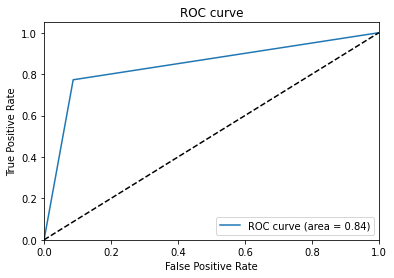

<Figure size 432x288 with 0 Axes>

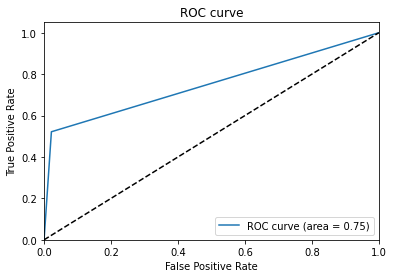

<Figure size 432x288 with 0 Axes>

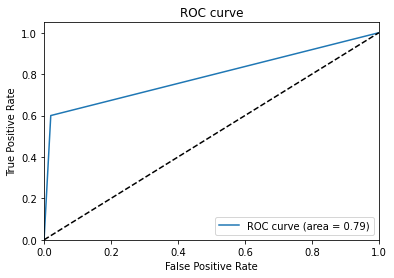

<Figure size 432x288 with 0 Axes>

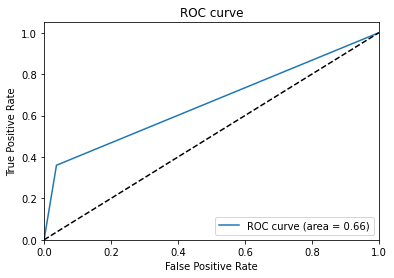

<Figure size 432x288 with 0 Axes>

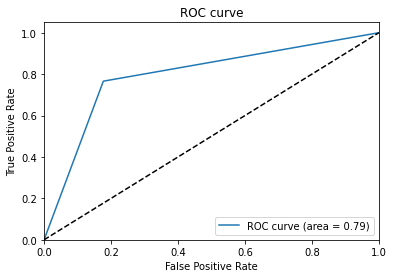

<Figure size 432x288 with 0 Axes>

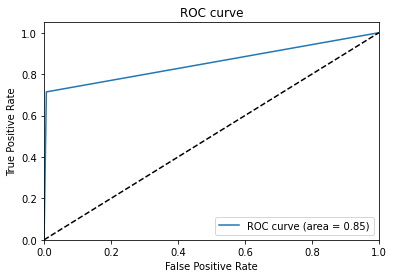

<Figure size 432x288 with 0 Axes>

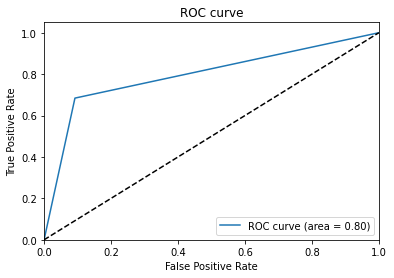

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot of a ROC curve for a specific class
for i in list(LANGUAGES_N.values()):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

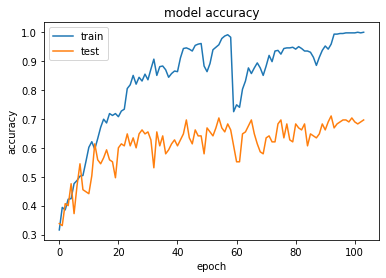

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(path_drive+'/Risultati/grafici/Model_Accuracyall_es.png')

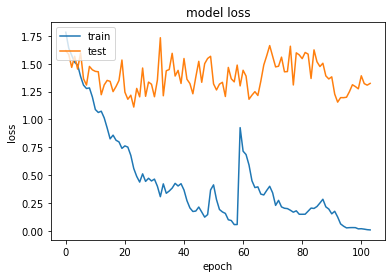

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(path_drive+'/Risultati/grafici/Model_Lossall_es.png')

# Sperimentazione senza Early Stopping

In [ ]:
def run_experiment_without_es(model, trainX, trainy, validationX, validationy, testX, testy):
  tf.random.set_seed(42)
  history = model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose, validation_data = (validationX, validationy)) 
  #model.summary()
  model.evaluate(testX, testy)
  predictions = model.predict_classes(testX) 
  print(predictions)
  return history, predictions

In [ ]:
# run the experiment
with tf.device('/device:GPU:0'):
  trainX, trainy, testX, testy, validationX, validationy = load_dataset(path_drive+'/'+dataset_dir)
  model = create_model()
  history, predictions = run_experiment_without_es(model, trainX, trainy, validationX, validationy, testX, testy)

(462, 350, 66) (462, 1)
(160, 350, 66) (160, 1)
(462, 350, 66) (462, 7) (160, 350, 66) (160, 7) (145, 350, 66) (145, 7)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


5/5 [==============================] - 3s 64ms/step - loss: 2.7225 - accuracy: 0.6250


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 0 0 0 2 2 0 1 0 0 3 0 4 4 0 1 6 4 6 0 1 2 2 2 0 3 2 1 4 0 0 1 3 1 2 2 0
 3 1 0 0 1 3 1 6 6 1 1 6 0 4 4 3 3 4 0 4 4 0 0 0 1 1 1 2 6 5 4 4 5 5 5 5 5
 5 4 3 5 5 3 3 4 4 4 4 4 4 4 4 4 3 3 3 3 4 3 6 2 4 4 4 4 4 4 4 4 4 4 4 4 4
 1 4 4 4 4 4 4 4 6 4 4 4 4 4 4 5 6 4 4 6 4 4 4 4 4 4 4 4 4 4 6 1 2 6 1 6 6
 2 6 6 6 6 6 0 0 0 6 3 3]


In [ ]:
from sklearn.metrics import classification_report

testy = np.argmax(testy, axis=1)
target_names = list(LANGUAGES.values())
print(classification_report(testy, predictions, target_names=target_names))

              precision    recall  f1-score   support

    Italiano       0.54      0.59      0.57        22
     Inglese       0.71      0.52      0.60        23
     Tedesco       0.50      0.60      0.55        10
    Spagnolo       0.65      0.44      0.52        25
    Olandese       0.65      0.83      0.73        47
       Russo       0.90      0.64      0.75        14
  Giapponese       0.50      0.53      0.51        19

    accuracy                           0.62       160
   macro avg       0.63      0.59      0.60       160
weighted avg       0.64      0.62      0.62       160



In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

vis_arr = multilabel_confusion_matrix(testy, predictions, labels = list(LANGUAGES_N.values()))
print(vis_arr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in list(LANGUAGES_N.values()):
    fpr[i], tpr[i], _ = roc_curve(testy == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
for j in (list(LANGUAGES_N.keys())):
  i = LANGUAGES_N[j]
  TP= valori.iloc[i,i]
  FP= valori.iloc[i,:].sum()-TP
  FN= valori.iloc[:,i].sum()-TP
  TN= valori.sum().sum() - TP - FP - FN
  print(TP,FP,FN,TN)
  #b=[[TP,FP],[FN,TN]]
  b=[[TP,TN],[FP,FN]]
  fig=plt.figure(figsize=(17,5))
  ax1=plt.subplot(121)
  sns.heatmap(b,annot=True,cmap="Blues",cbar=False,fmt = "g")
  #plt.xlabel("POSITIVI") 
  #plt.ylabel("NEGATIVI")
  tick_marks = [0.5,1.5]
  plt.title(LANGUAGES[j])
  plt.xticks(tick_marks, ["P","N",])
  plt.yticks(tick_marks, ["T","F"])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

valori=pd.crosstab(predictions,testy)
fig=plt.figure(figsize=(17,5))
ax1=plt.subplot(121)
ax1.set_title("spagnolo e giapponese")
sns.heatmap(valori,annot=True,cmap="Blues",cbar=False)
plt.xlabel("attuali") 
plt.ylabel("predetti")

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()